# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

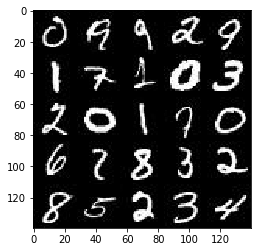

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

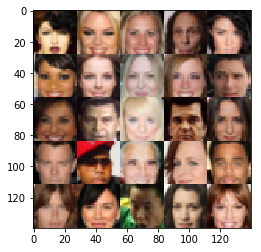

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')
  
    return inputs_real, inputs_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):   
        
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.dropout(x3, 0.9)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, 
              kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        #x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, 
              kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.dropout(x3, 0.9)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
       
        out = tf.tanh(logits) 
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt,  g_opt  = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batches in get_batches(batch_size):
                steps += 1
                
                # Because of tanh activation in generator function
                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                # Seen in thread from forum
                batches *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                # added learning_rate in dict
                _ = sess.run(d_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batches})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6110... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 1.1029
Epoch 1/2... Discriminator Loss: 1.5731... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.9815... Generator Loss: 0.3119
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.9480... Generator Loss: 0.2797
Epoch 1/2... Discriminator Loss: 1.7777... Generator Loss: 0.3446
Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.7646... Generator Loss: 0.3401
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.8059


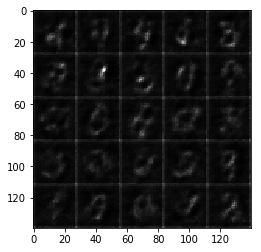

Epoch 1/2... Discriminator Loss: 1.6882... Generator Loss: 0.4388
Epoch 1/2... Discriminator Loss: 1.5075... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 1.6474... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.5449


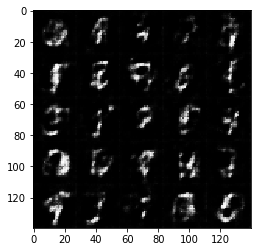

Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 0.9335... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 1.5455
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 2.1284


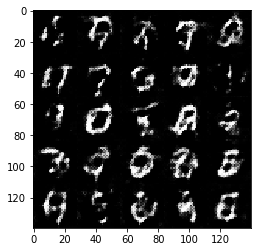

Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 1.6090
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.4156
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.3985
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.8075


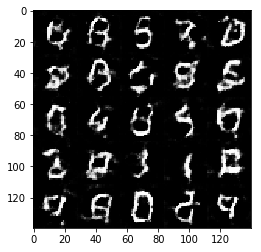

Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.5217
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 1.4984
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 1.4649
Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.4872
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.6300... Generator Loss: 0.3568


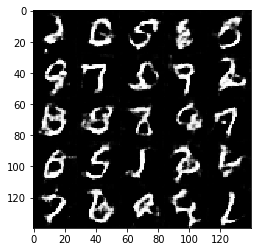

Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 1.4268
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 1.3038
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.4458
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 1.2573
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 1.1415
Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 1.2026
Epoch 1/2... Discriminator Loss: 1.7436... Generator Loss: 1.7567


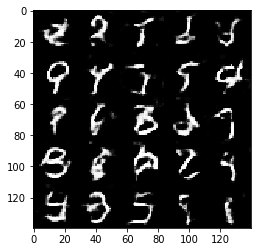

Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.6022
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 1.0558
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 1.5501... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 2.6150... Generator Loss: 0.1507
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.1783
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.3854
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 1.4446


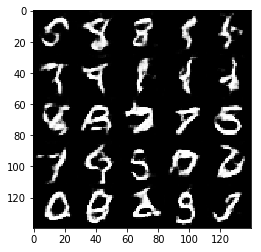

Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 1.6004
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.0823
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.3171
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 1.4082


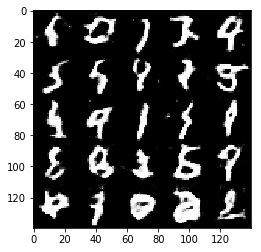

Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 1.9453
Epoch 1/2... Discriminator Loss: 0.9298... Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 1.0006... Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 1.6887
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.3792


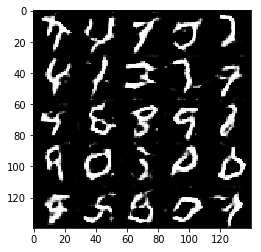

Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 0.6163
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.1041
Epoch 1/2... Discriminator Loss: 0.9681... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 3.1551... Generator Loss: 3.6609
Epoch 1/2... Discriminator Loss: 0.8892... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 1.5822
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.6367


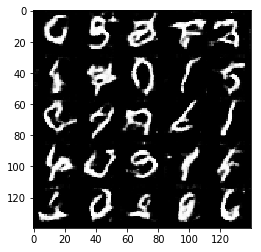

Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 0.9774... Generator Loss: 2.3371
Epoch 1/2... Discriminator Loss: 0.8761... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 1.0357
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.7452
Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 1.3649
Epoch 1/2... Discriminator Loss: 0.8691... Generator Loss: 1.7590


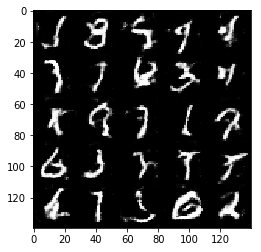

Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 1.9686
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.5049
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 0.9630... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 0.9113... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 1.7838... Generator Loss: 0.3622


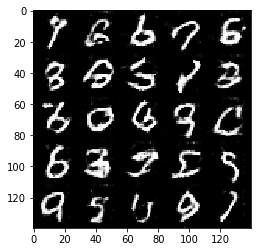

Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 1.4722
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 0.9670... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 0.8576... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.2057
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 1.2503
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 0.9607


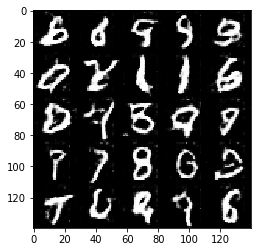

Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 1.3377
Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 1.0052
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 0.8704... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 0.6627


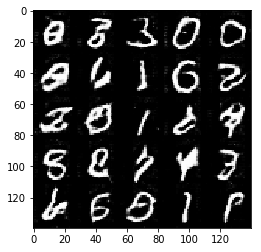

Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.5324
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.5884
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.4858
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.2484
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.6061


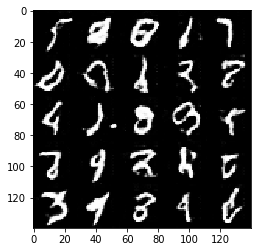

Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 1.7204
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 1.1623
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 1.6518... Generator Loss: 2.2371
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.1481
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 1.4785
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 1.4768
Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.0478


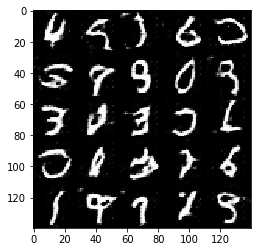

Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.5512
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 1.6207... Generator Loss: 0.3973


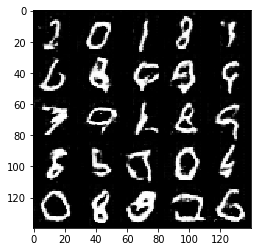

Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.3787
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 0.8578... Generator Loss: 1.2014
Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 1.0189


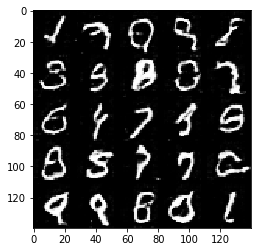

Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.2003
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.6825
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 1.4479
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.5421
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.5953
Epoch 1/2... Discriminator Loss: 0.6705... Generator Loss: 1.4809


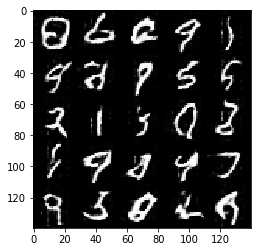

Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 2.6700
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.0863
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 1.5655
Epoch 1/2... Discriminator Loss: 0.6668... Generator Loss: 1.9512
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 1.7664... Generator Loss: 0.3932


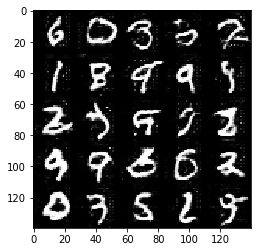

Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 1.5672... Generator Loss: 0.4073
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.4787
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.1420
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.2582
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 0.9779
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 1.5687
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 0.9836


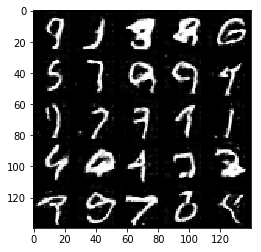

Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.2386
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.3203
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.6728
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.4021


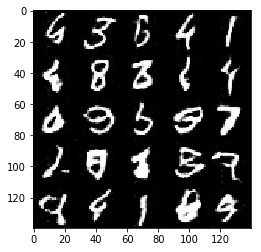

Epoch 2/2... Discriminator Loss: 0.7505... Generator Loss: 1.4445
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 2.3000
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 2.1625
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.3238
Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 1.5918
Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.2442
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.5568


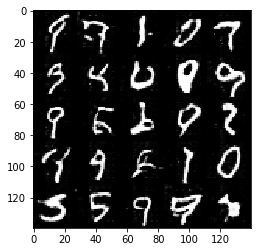

Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 0.8813
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 1.5988
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.7148
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.4034
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 0.9364
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 1.0119


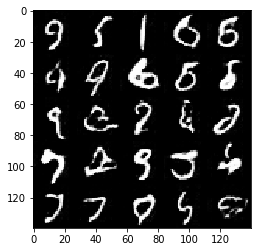

Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 1.8752
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 2.2245
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.2229
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 1.1698
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.2684
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.2806
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 0.9407


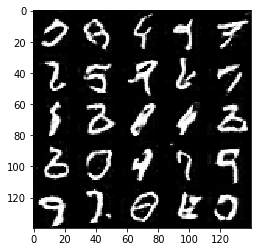

Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.7589
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.2028
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.0971
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.1635
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 2.2799
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.1889
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 1.1707


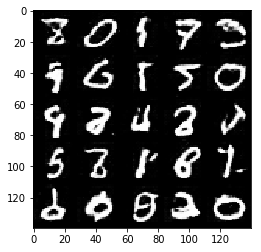

Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.5390
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.4949
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 1.6773
Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.5414
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.4772
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.2145
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.5973
Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 1.3346
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 1.2027


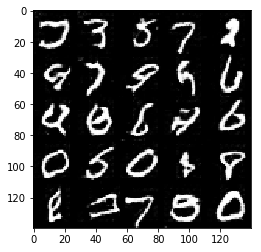

Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 1.3297
Epoch 2/2... Discriminator Loss: 0.8073... Generator Loss: 1.1341
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.1439
Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.8145
Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 1.7398
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.1502
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.8292


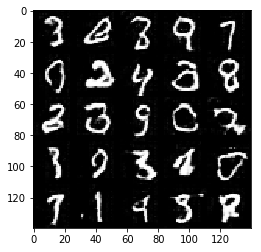

Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.4204
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.1802
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.5588
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.2223
Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.0870
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 1.2317
Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 0.8013


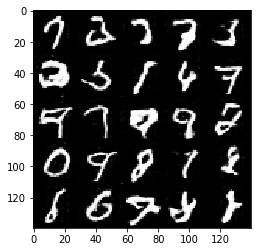

Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.2063
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 0.9693
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.6325
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 2.0106
Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 2.0591
Epoch 2/2... Discriminator Loss: 1.7855... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9139


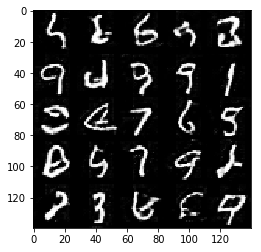

Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.1649
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.4775
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.2124
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 0.9919
Epoch 2/2... Discriminator Loss: 0.8496... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.0231


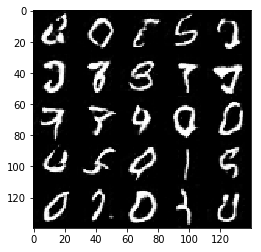

Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 2.0017
Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 1.3354
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 1.2288
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.5761
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.8255
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 1.2110
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.6121
Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.2545


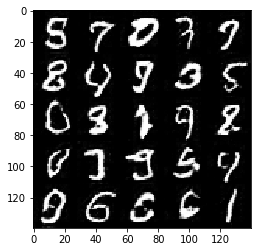

Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 1.4669
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 1.4397
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.6355
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 1.3126
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.8822
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.4374


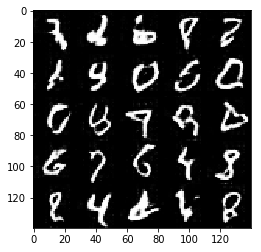

Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.0721
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.3839
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.6005
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 0.8406... Generator Loss: 1.2207
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.8845
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.9716


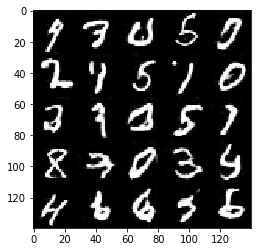

Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 0.5108... Generator Loss: 2.2205
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.2878
Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 2.8865
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 1.3287
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.6081
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 0.9817


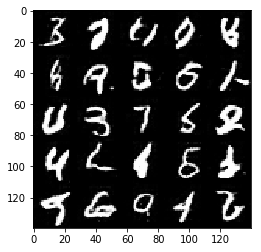

Epoch 2/2... Discriminator Loss: 1.7208... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.3801
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.9532
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.0382
Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 1.4724
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 1.9850
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 0.6601... Generator Loss: 1.5641


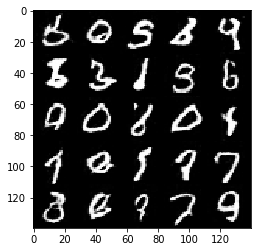

Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.9143
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.1109
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 1.8530
Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.9580
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.4580
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.8282


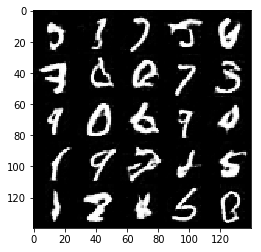

Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.2612
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 1.7954
Epoch 2/2... Discriminator Loss: 0.8070... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 1.3934
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.0885
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 1.2921
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 2.1177
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 1.0205


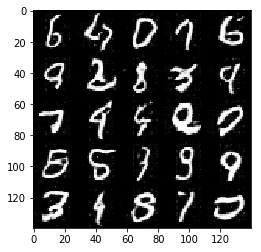

Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 0.9430
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.3151
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.4404
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 1.6813
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.1070
Epoch 2/2... Discriminator Loss: 0.7722... Generator Loss: 1.2891
Epoch 2/2... Discriminator Loss: 0.8344... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.2359


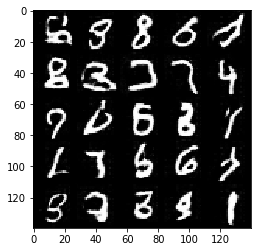

Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 0.8831
Epoch 2/2... Discriminator Loss: 0.9920... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 0.8573
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.3093
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 0.6284... Generator Loss: 1.5398
Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.6347
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 2.5968


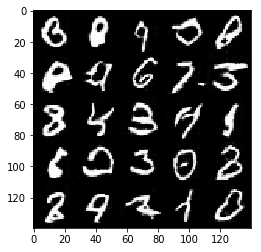

In [12]:
batch_size = 30
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.5394... Generator Loss: 0.1771
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.9297... Generator Loss: 0.3010
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 2.0492
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 2.3440... Generator Loss: 0.2034
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.7838


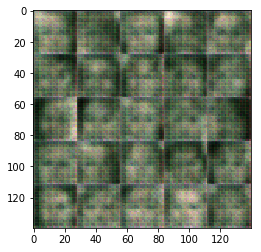

Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 5.2878
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 4.2530
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 5.3123
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 2.3319
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.7331
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 5.0294
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.7012
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.5947


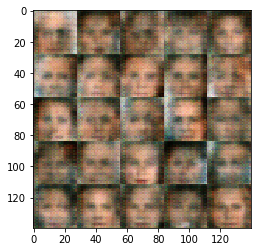

Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.3842
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 3.1991
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 4.1823
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 3.9593
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.2599
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.0048


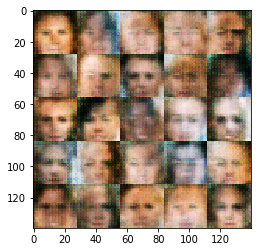

Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.2490
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.1558
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.9289
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.1013


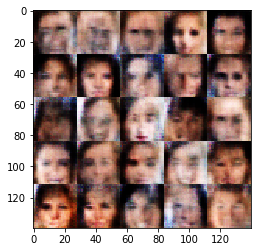

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 3.0751
Epoch 1/1... Discriminator Loss: 1.7566... Generator Loss: 2.7949
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 2.2758
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 3.8978
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 2.3161
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 1.7444... Generator Loss: 2.1762
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.3033


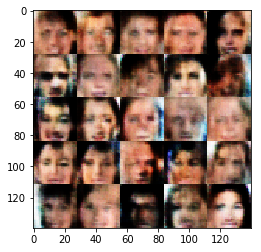

Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.9397
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 4.4416
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 5.3269
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 2.4496
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 4.2158
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 2.1422
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 2.9139
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 2.5131


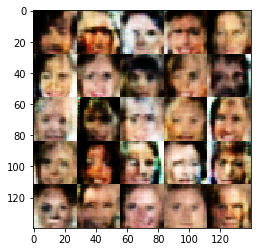

Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 2.4448
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 2.7838
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 2.6308
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 3.6816
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 2.0664
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.6156
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 2.7337
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 2.5680
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.9549


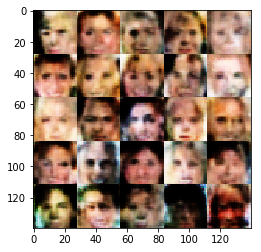

Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 3.2661
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.1597
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.2596
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 2.1239
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.9249
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 3.9331
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 2.6806


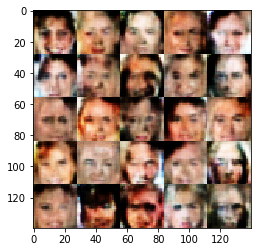

Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 3.1455
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 2.9201
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.9263
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 3.2729
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 2.6670
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 3.0356
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 3.8238
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 3.3988
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 3.3983
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 2.2771


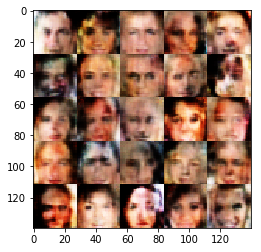

Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 4.2645
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.5135
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 3.2954
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 4.4765
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 0.4240... Generator Loss: 3.9924


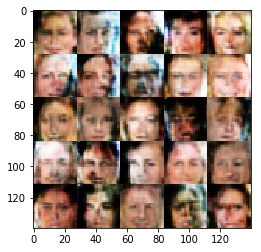

Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.4176
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.5352
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 2.5146
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 3.1681
Epoch 1/1... Discriminator Loss: 0.3770... Generator Loss: 4.0251
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.8846
Epoch 1/1... Discriminator Loss: 2.3366... Generator Loss: 3.1090
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 3.2976


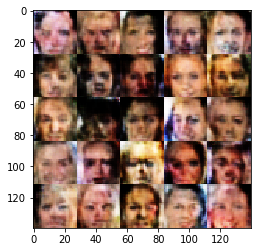

Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 2.1625
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 3.2905
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 2.9936
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.9163
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 1.8820
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 3.4087
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 2.4513
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.6816


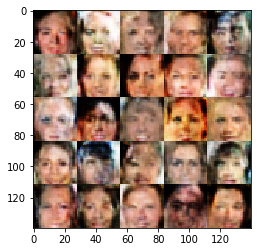

Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 1.7886... Generator Loss: 0.3043
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.2526
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 2.6623
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 2.9816
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.7446


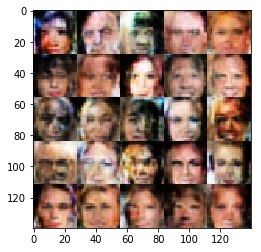

Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 3.4302
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 3.6587
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 2.8321
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 3.8644
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.7192


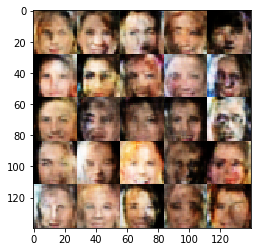

Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 2.7238
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 4.8078
Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 2.5425
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 2.6175
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.6875
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 2.9127
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 3.9160


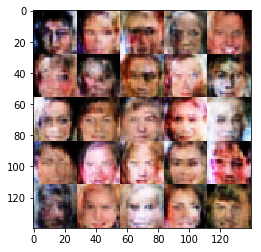

Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 4.1968
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 2.1612
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 3.2262
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 2.6924
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 2.2230
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 4.8560
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 1.7905
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 2.1375


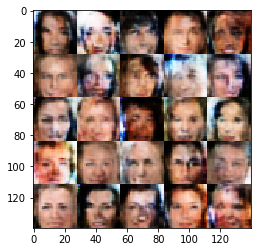

Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 3.1260
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 2.1667
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.5572
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 2.6613
Epoch 1/1... Discriminator Loss: 0.5388... Generator Loss: 3.1690


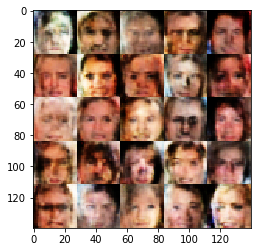

Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.2012
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 2.9659
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 1.7564
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.3571
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.5924
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.7396
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 3.0811
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.4334


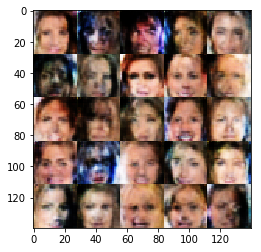

Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.6324
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.8737
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 2.5084
Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 2.5245
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 2.6176
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 1.9582


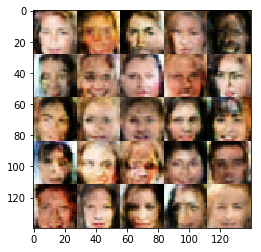

Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.9810
Epoch 1/1... Discriminator Loss: 2.1638... Generator Loss: 0.2192
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.6424
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 2.3725
Epoch 1/1... Discriminator Loss: 1.7723... Generator Loss: 3.8846


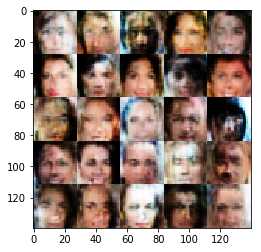

Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 3.9484
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 4.1326
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 2.8705
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 5.1571
Epoch 1/1... Discriminator Loss: 0.4222... Generator Loss: 3.4847
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 4.2284
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 4.6922


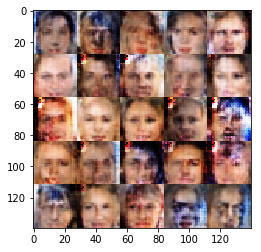

Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 3.7126
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 4.0947
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 3.9015
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 2.9116
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 5.3942
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 3.5810
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 3.7311
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 3.9290
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 2.2612


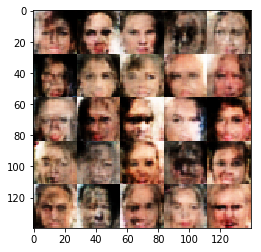

Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 2.1837
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 3.3022
Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 1.7573
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 2.5829
Epoch 1/1... Discriminator Loss: 2.3070... Generator Loss: 0.2229
Epoch 1/1... Discriminator Loss: 1.8356... Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.8566


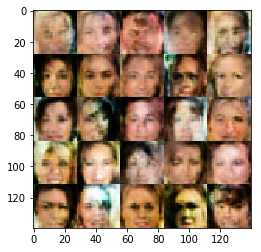

Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 2.8664
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 2.9096
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 2.1940
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.4354
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 2.2961
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.6334


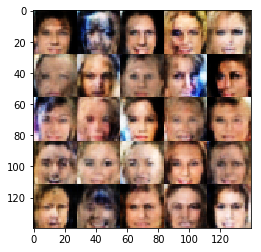

Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 3.9819
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.9680
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 3.1483
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 2.9835
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.5354


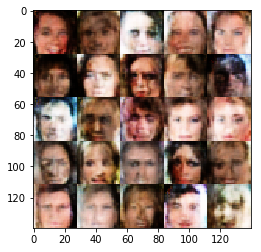

Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 1.9266
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.7730
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 4.0851
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 2.3077
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.6615


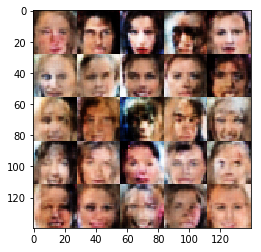

Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.4334
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 2.3821
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 2.2797
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.6406
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 2.4536


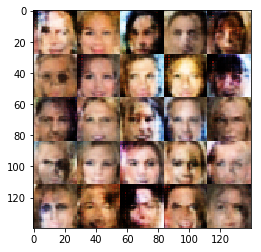

Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 2.2982
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.4255
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 2.5188
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.7248
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.3439
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.8621
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 2.3012


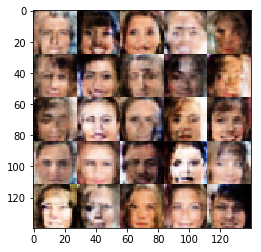

Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.3119
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 3.7328
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.1030
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 2.2470... Generator Loss: 0.1791
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 2.8513


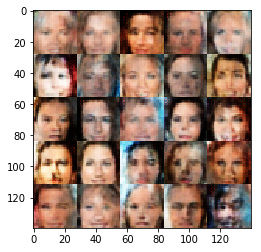

Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 7.3749
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 2.4890
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 5.2922
Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 5.4608
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 7.7274
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 3.2108
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 6.4559
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 4.1060
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 4.3163


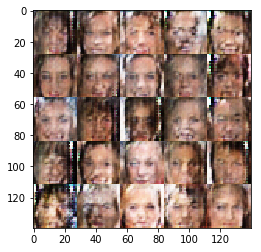

Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 6.1364
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 5.1586
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.9202
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 4.2875
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.1838
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 5.5349
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 5.6615
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 2.5490
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 2.0926
Epoch 1/1... Discriminator Loss: 1.8900... Generator Loss: 0.3281


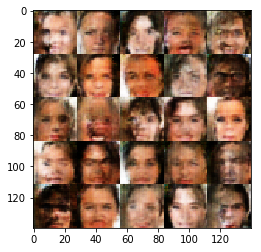

Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 4.2601
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.3257
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 5.2138
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.7856
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.5432
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.5745
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 2.7677
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 2.3173
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.7689
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.9446


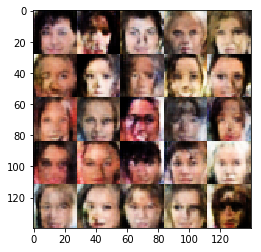

Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.4106
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 2.5945
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.1379
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 2.2631
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 2.3189
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 3.0258
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.1414


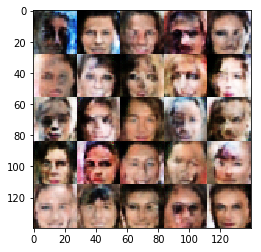

Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 2.0859
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 2.9326
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.2185


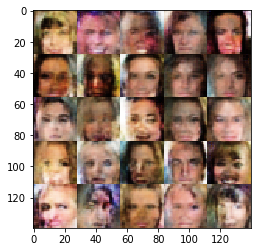

Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 0.6244... Generator Loss: 1.6915
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 1.8958
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.5196
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.6994
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.9803


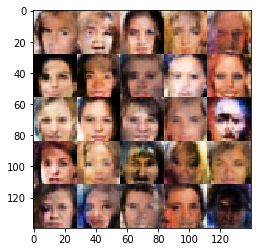

Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 2.1130
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 2.0977
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 2.1001
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.8718
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.2002


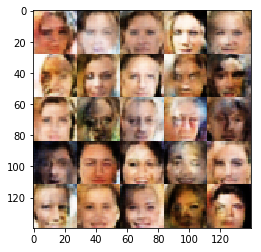

Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 2.1714... Generator Loss: 0.2067
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 3.6396
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 1.8098
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.6536


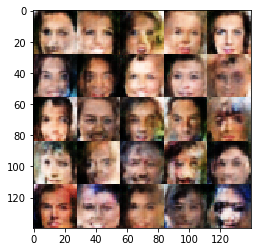

Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.8251
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 4.3849
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.7168... Generator Loss: 0.3506
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.7445
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 1.9083


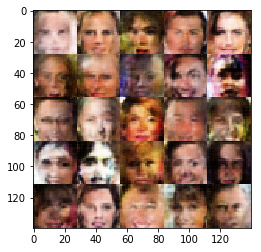

Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.8436... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.4462
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 3.1022
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.5217
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.2109


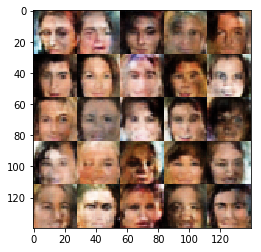

Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 2.5425
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 3.5446
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.7620


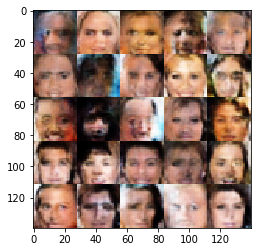

Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.5476
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.8119
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.7444... Generator Loss: 0.3679


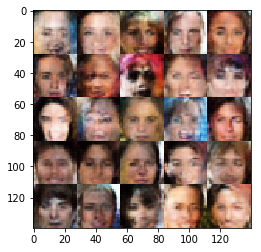

Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 2.1544
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 2.0841
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 2.9117
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 6.3510
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.8228
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 1.5206


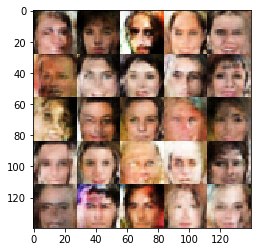

Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.5946
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 5.7775
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 3.1762
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 2.6555
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 8.2782
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.1107
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.3494
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.9558
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 4.5390
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.1572


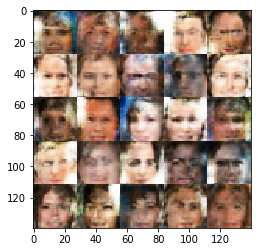

Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 2.8144
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.7089
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.9932
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.4982
Epoch 1/1... Discriminator Loss: 1.9771... Generator Loss: 0.2723
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.4793


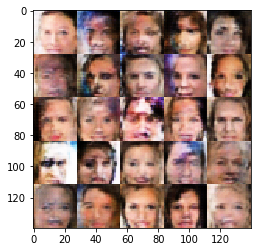

Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 2.0782
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 2.1821
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.6345
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 3.1960
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.8939


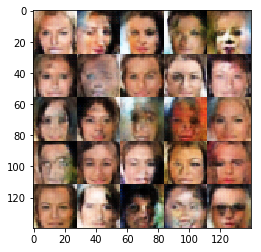

Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.4926
Epoch 1/1... Discriminator Loss: 1.9224... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 2.3180
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 1.7805
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 3.6981
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.4393


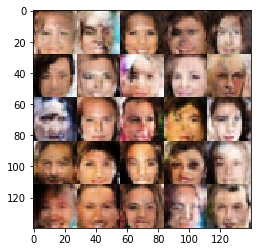

Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.4503
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.5934
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.4065
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.8633
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 0.7545


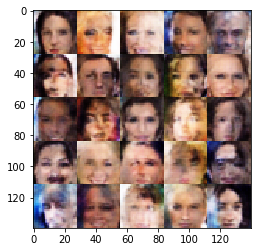

Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.6237
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.8478
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.7662
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.4952
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.8385
Epoch 1/1... Discriminator Loss: 1.7487... Generator Loss: 0.3057
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 2.0088


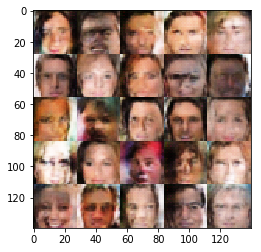

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 0.3463
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.4421
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 2.1117
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.7270


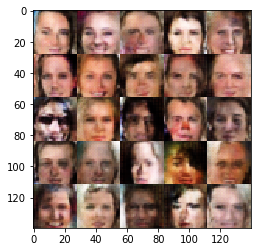

Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 3.2771
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.0196
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7160


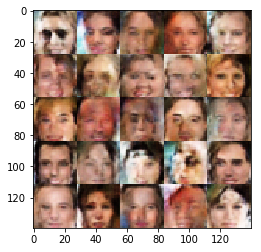

Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 2.2937... Generator Loss: 0.1884
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 3.2668
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 2.2073
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.0828


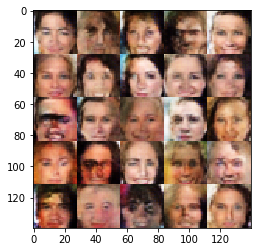

Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 1.8080
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.5549
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9470


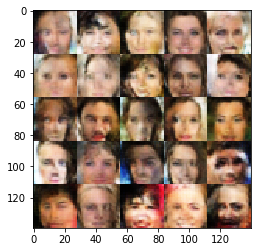

Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 0.9512


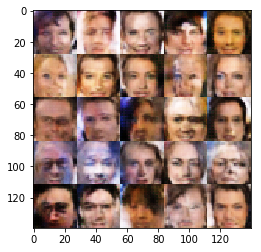

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.8633
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.5325
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.4955
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.1694


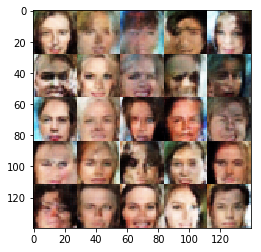

Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.2401


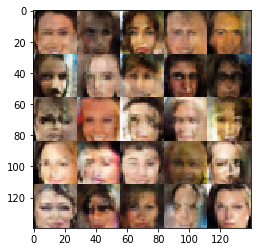

Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.3990
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.5580
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.9760
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.5249
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.6955


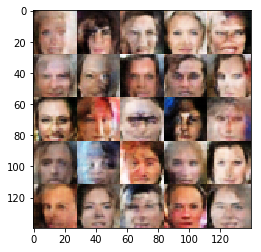

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.8538
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 3.3468


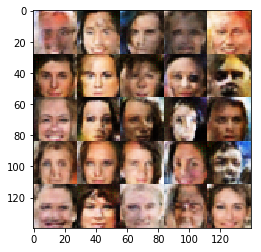

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.8792
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 1.8398
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 2.9343
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 2.0310
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.6753... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5728


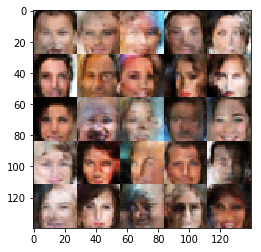

Epoch 1/1... Discriminator Loss: 1.7075... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.8427
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.9949


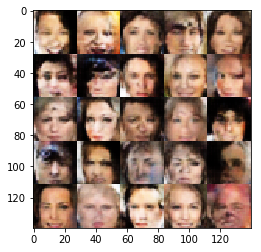

Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.9949


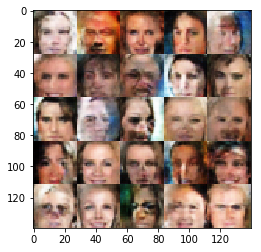

Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.1453


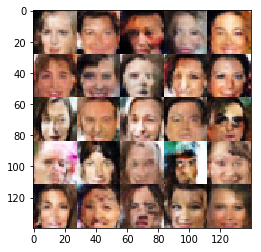

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 2.1882
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.2662


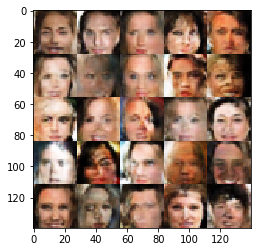

Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.5303
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.9514... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.2258


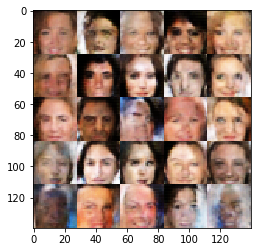

Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.5243
Epoch 1/1... Discriminator Loss: 2.0448... Generator Loss: 0.2419
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 2.5592
Epoch 1/1... Discriminator Loss: 2.5223... Generator Loss: 0.1346
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.9323... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.5925


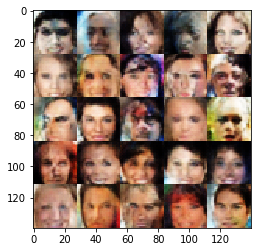

Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.9414
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.8470
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.4846


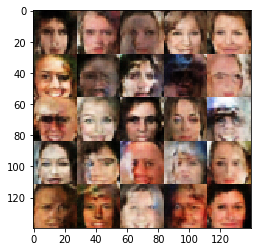

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.5521
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.6231
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.0084


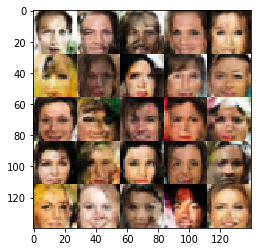

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.8934


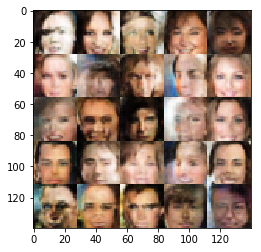

Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.8114


In [13]:
batch_size = 30
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.